<a href="https://colab.research.google.com/github/singularity014/BERT_sentiment_analysis_quick/blob/master/BERT_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I - Import Dependencies

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random

from google.colab import drive

In [2]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 2.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=28a9bcf589b295ad4b5037554b63b3ee6a68fa8a14dcc30f5f46ac911db8675a
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=29f4881b45b75b16c4db7707543cfd21cca5ee6acd9d7d8e70722bc22940bf22
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=48b4c19d51e4798cba0c865d2d5ccd192ae936f4636bd010b129514e085e79a3
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 3.4MB/s 


In [3]:
# setting tf version to 2.x
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
tf.__version__

'2.2.0'

# II - Data Preprocessing

### Loading files


---
The link to the data is provided in README file of github



In [4]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# data cols
cols = ["sentiment", "id", "date", "query", "user", "text"]
# loading via google drive path
data = pd.read_csv(
    "/content/drive/My Drive/sentiment_data/train_data.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

data.drop(["id", "date", "query", "user"],
          axis=1,
          inplace=True)

In [6]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Data Cleaning

In [7]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    return tweet


#

In [8]:
# clean the data
data_clean = [clean_tweet(tweet) for tweet in data.text]
# checking first few cleaned data
data_clean[:5]

[" Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!",
 ' I dived many times for the ball. Managed to save The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 " no it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]

In [9]:
# changing label 4 to 1, because negative lables 
# are indicated as 4 in the dataset, hence converting them to 1
# for 0/1 conventional label
data_labels = data.sentiment.values
data_labels[data_labels == 4] = 1

### BERT Tokenization

STEP 1 - 

Before using BERT Tokenizer, note that we need some following info. 
*   Vocabulary details of BERT Model(path of vocab file)
*   Whether they are lower cased or not.
*   We will use BERT style Tokenization.
Create a BERT layer to get both the info.




STEP 2 -

Now that we all these info, we can create BERT tokenizer object.



In [10]:
# STEP 1
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()


In [11]:
print(f'path to vocab file is : {vocab_file}') # will give us the vocab.txt file address
print(f'Is LOWER CASE ? : {do_lower_case}') # will tell use whether to lower case or not 

path to vocab file is : b'/tmp/tfhub_modules/03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/assets/vocab.txt'
Is LOWER CASE ? : True


In [12]:
# STEP 2
FullTokenizer = bert.bert_tokenization.FullTokenizer
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [13]:
# Tokinizer check 
tok_sent = tokenizer.tokenize('I love hiking!')
print(f'Toenized Sentence - {tok_sent}')

# How to convert to numbers? i.e. word2index counterpart of keras utility
print(f"Tokens to Index - {tokenizer.convert_tokens_to_ids(tokenizer.tokenize('I love hiking!'))}")

Toenized Sentence - ['i', 'love', 'hiking', '!']
Tokens to Index - [1045, 2293, 13039, 999]


In [14]:
# BERT Style tokenization
# Note that convert_tokens_to_ids is similar 
# to texts_to_sequences in tf.keras utility
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [15]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]
data_inputs[0]

[22091,
 2860,
 2860,
 2008,
 1005,
 1055,
 1037,
 26352,
 5017,
 1012,
 2017,
 2323,
 2050,
 2288,
 2585,
 12385,
 1997,
 2353,
 2154,
 2000,
 2079,
 2009,
 1012,
 1040]

### Data Creation


                     Overview
    
Minimized padding strategy (Batch Padding)
*   We will first pad the data, but we will  perform padding according to length of sentences present in each batch.
*   We will Create batch in such a way that each batch will have sentences of similar length.

*   With this strategy we will lose less data because of padding, because the paddings will be less.
*   We will shuffle them so that same labeled data dont often appear in same batch.
*   NOTE - We will have to do the training in batches, hence we could leverage padding per batch.




In [16]:
# [ 
    # [<'sent encoded'> , <'label'>, <'sent len'>]...
# ]

data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
# shuffling data
random.shuffle(data_with_len)
# sort the data by sentences lengths 
data_with_len.sort(key=lambda x: x[2])

# keep the data and label pair if the sentence length is greater than seven.
# to get rid of smaller sentences.
sorted_all = [(sent_lab[0], sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [17]:
sorted_all[0]

([5292, 2232, 2204, 2017, 2323, 3582, 2033, 1012], 1)

In [18]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [19]:
next(iter(all_dataset))

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([5292, 2232, 2204, 2017, 2323, 3582, 2033, 1012], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [20]:
# BATCHING
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [21]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

# III- Model Building

Now that we have batches of our data ready, we can build any classification model over it. Let us see how to feed it to a CNN model(It can be replaced with LSTM/GRU too.

Below is a 1-D Conv Net.
 - 6 feature detectors (We'll give more)
 - 3 different size of filters to detect different types of correlation between the words.
 - 2 feature map for each region sizeby max pooling.
 - We concatenate the outputs .






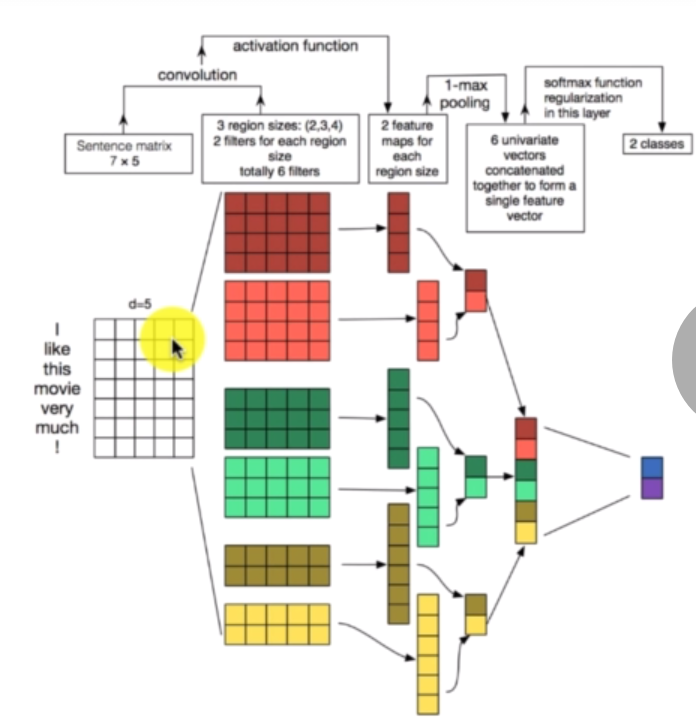


In [23]:
# MODEL class
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# IV - Model Training


In [24]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 5

In [25]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [26]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [34]:
checkpoint_path = "/content/drive/My Drive/DCNN_model/"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [35]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [ ]:
Dcnn.fit(train_dataset,
         epochs=NB_EPOCHS,
         callbacks=[MyCustomCallback()])

Epoch 1/5
  30720/Unknown - 2280s 74ms/step - loss: 0.3876 - accuracy: 0.8257

# V- Model Evaluation & Prediction

In [ ]:
results = Dcnn.evaluate(test_dataset)
print(results)

In [ ]:
def get_prediction(sentence):
    tokens = encode_sentence(sentence)
    inputs = tf.expand_dims(tokens, 0)

    output = Dcnn(inputs, training=False)

    sentiment = math.floor(output*2)

    if sentiment == 0:
        print("Ouput of the model: {}\nPredicted sentiment: negative.".format(
            output))
    elif sentiment == 1:
        print("Ouput of the model: {}\nPredicted sentiment: positive.".format(
            output))

In [ ]:
get_prediction("This movie was pretty interesting.")

# Conclusion

So we just saw the demo of using BERT Tokenizer utility. We tokenized and saw a mechanism to to minimize data loss through padding by doing batching.
Note that goal of the above solution is to get an idea of how BERT tokenizer could be used and glued with model building. It can be any other model.